# Defect Classification Model

Here, we build a model to classify defects on a metal surface using Transfer Learning (with VGG16 base model).

**Dataset:** [Metal Surface Defects Dataset](https://www.kaggle.com/fantacher/neu-metal-surface-defects-data)

## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive")

In [1]:
import matplotlib
matplotlib.use("Agg")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from keras.applications import VGG16
from keras.layers.core import Flatten, Dense, Dropout
from keras.preprocessing import image
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

## Model Architecture [Using VGG16 as Base Model]

In [2]:
CLASSES = 6       # Here, there are 6 classes of defects ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled','Scratches']
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

In [3]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(WIDTH, HEIGHT, CHANNELS)))

# Enable Transfer Learning by freezing weights of the base VGG16 Model
for layer in baseModel.layers:
	layer.trainable = False

model = Sequential()
model.add(baseModel)
model.add(Flatten(name="flatten"))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation='softmax'))

58892288/58889256 [==============================] - 1s 0us/step


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

## Dataset Preparation

In [ ]:
# Image preprocessing for robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 36

print("[INFO] loading images...")
train_data_dir = "/content/drive/My Drive/Defect_data/train"        # directory of training data
valid_data_dir = "/content/drive/My Drive/Defect_data/valid"        # directory of validation data
test_data_dir = "/content/drive/My Drive/Defect_data/test"          # directory of test data

training_set = train_datagen.flow_from_directory(train_data_dir, 
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE, 
                                                 class_mode='categorical')
validation_set = train_datagen.flow_from_directory(valid_data_dir, 
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE, 
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_data_dir, 
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size=BATCH_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

[INFO] loading images...
Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


## Model training

In [ ]:
print("[INFO] compiling model...")

model.compile(
    loss="categorical_crossentropy", 
    optimizer = Adam(lr=0.001), 
    metrics=["accuracy"]
)

[INFO] compiling model...


In [ ]:
print("[INFO] training model...")

EPOCHS = 10

history = model.fit(
    training_set,
    epochs=EPOCHS,
    steps_per_epoch=training_set.samples//BATCH_SIZE,
    validation_data=validation_set,
    validation_steps=validation_set.samples//BATCH_SIZE
)

[INFO] training model...
Epoch 1/10
46/46 [==============================] - 24s 511ms/step - loss: 0.3615 - accuracy: 0.8829 - val_loss: 0.0844 - val_accuracy: 0.9722
Epoch 2/10
46/46 [==============================] - 23s 502ms/step - loss: 0.3199 - accuracy: 0.8949 - val_loss: 0.0735 - val_accuracy: 0.9861
Epoch 3/10
46/46 [==============================] - 23s 500ms/step - loss: 0.2741 - accuracy: 0.8919 - val_loss: 0.0731 - val_accuracy: 0.9722
Epoch 4/10
46/46 [==============================] - 24s 520ms/step - loss: 0.2692 - accuracy: 0.9070 - val_loss: 0.0610 - val_accuracy: 0.9861
Epoch 5/10
46/46 [==============================] - 24s 515ms/step - loss: 0.2542 - accuracy: 0.9046 - val_loss: 0.0612 - val_accuracy: 0.9861
Epoch 6/10
46/46 [==============================] - 23s 503ms/step - loss: 0.2611 - accuracy: 0.9052 - val_loss: 0.0440 - val_accuracy: 0.9861
Epoch 7/10
46/46 [==============================] - 23s 499ms/step - loss: 0.2417 - accuracy: 0.9155 - val_loss: 0.03

In [ ]:
# Save the model
print("[Info] serializing network...")
model.save("defect_classification_vgg16.hdf5")

[Info] serializing network...


In [ ]:
# Function to plot the accuracy & losses over epochs of training

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b*--', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'rD:', label="Validation Accuracy")
    plt.legend()
    plt.title('Training and validation accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b*--', label="Training Loss")
    plt.plot(epochs, val_loss, 'rD:', label="Validation Loss")
    plt.legend()
    plt.title('Training and validation loss')
    
    plt.savefig("defect_classification_model.png", bbox_inches="tight")
    plt.show()

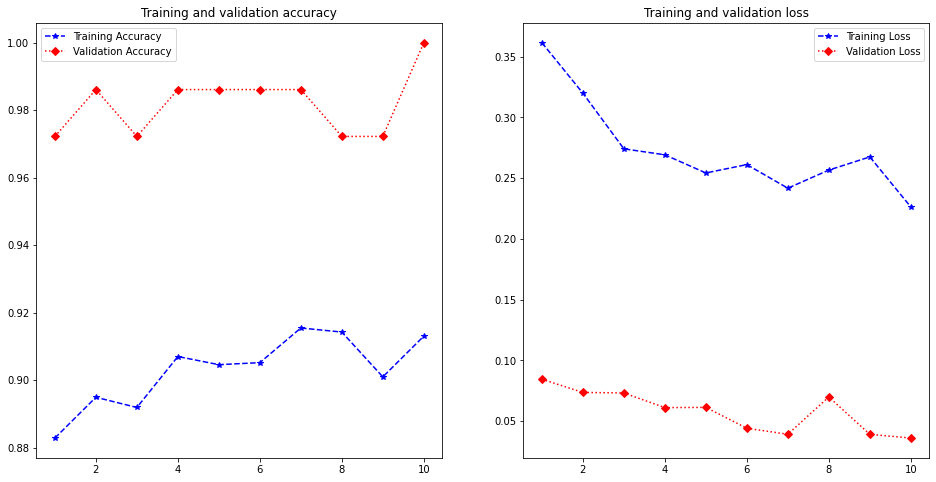

In [ ]:
plot_training(history)

## Model Evauation

In [ ]:
score = model.evaluate(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 6s 3s/step - loss: 0.0356 - accuracy: 1.0000
Test loss: 0.035601869225502014
Test accuracy: 1.0


In [ ]:
pred = model.predict(
    test_set, 
    steps=test_set.samples//BATCH_SIZE + 1,
    verbose=1
)
pred = np.argmax(pred, axis=1)

2/3 [===================>..........] - 0s 185ms/step


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_set.classes[test_set.index_array], pred))

print('\nClassification Report')
target_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled','Scratches']
print(classification_report(test_set.classes[test_set.index_array], pred, target_names=target_names))

Confusion Matrix
[[12  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]

Classification Report
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       1.00      1.00      1.00        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      1.00      1.00        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

